# Reviewer/Contributor Heatmap Discussion Notebook


This notebook will be the development ground for an activity heatmap from the perspectives of: 
- Contributors (Someone who has had a PR merged on the specific segment of the codebase) 
- Reviewers (Someone who has reviewed a PR on the specific segment of the codebase)

The x axis will be a break down of the repository folders and source files. The first iteration will statically show the source directory folders and files. The next iteration will allow users to select a more granular view on specific sections of the codebase. A part of this notebook review will be to get suggestions and feedback on how to impliment this. 

The initial concept of the visualization is as followed:

User selects which specific repository in the repositories in their search bar to show on heat map
User specifies a time interval in days that a reviewer needs to show some form of activity in the overall repo set
Then one of the following plotly heat maps is used:
https://plotly.com/python/heatmaps/
https://plotly.com/python/2D-Histogram/

- x axis: date by month in descending order
- y axis: repository folder (or file, need to workshop this a bit)
- z axis (color): Number of reviewers that have been active in the time interval (relative to the month block)

This notebook does all of the preprocessing down to the visualization for we can try different strategies before putting it into 8Knot

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import plotly.express as px
import datetime as dt
import plotly
import math
from IPython.display import Image

# connect to db
import json
import os

paths = ["../../comm_cage.json", "comm_cage.json", "../../config.json", "../config.json", "config.json", "../../copy_cage-padres.json"]

for path in paths:
    if os.path.exists(path):
        with open(path) as config_file:
            config = json.load(config_file)
        break
else:
    raise FileNotFoundError(f"None of the config files found: {paths}")
        
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})


In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

Get repo_ids for augur data access 

In [3]:
repo_urls = ['https://github.com/opendatahub-io/data-science-pipelines-operator','https://github.com/pulp/pulp-infra-ansible'
             ,'https://github.com/opendatahub-io/data-science-pipelines','https://github.com/chaoss/augur']

In [4]:
from sqlalchemy import text, bindparam

repo_urls = [
    'https://github.com/opendatahub-io/data-science-pipelines-operator',
    'https://github.com/pulp/pulp-infra-ansible',
    'https://github.com/opendatahub-io/data-science-pipelines',
    'https://github.com/chaoss/augur'
]

stmt = text("""
    SELECT DISTINCT
        r.repo_id,
        r.repo_name
    FROM repo r
    JOIN repo_groups rg ON r.repo_group_id = rg.repo_group_id
    WHERE r.repo_git IN :urls
""").bindparams(bindparam("urls", expanding=True))

with engine.connect() as conn:
    rows = conn.execute(stmt, {"urls": repo_urls}).all()

repo_ids   = [row[0] for row in rows]
repo_names = [row[1] for row in rows]
print(repo_ids)
print(repo_names)

[1, 226775, 227428, 227448]
['augur', 'pulp-infra-ansible', 'data-science-pipelines-operator', 'data-science-pipelines']


This visualization is to be done on a single repo but we will use the 4 repo_ids to test out the stategy on difference file structures and contributor density

In [5]:
repo_id = 1

## File query and preprocessing

Query to get all the files identified in the repo_labor table for the specific repository. For each collection of repo_labor, every file in current (as of that collection) existance is a row. During the preprocessing steps we will only keep the entries from the most recent collection

In [6]:
file_query = salc.sql.text(f"""
                SELECT 
                    rl.repo_id,
                    r.repo_name,
                    r.repo_path,
                    rl.rl_analysis_date,
                    rl.file_path,
                    rl.file_name
                FROM 
                    repo_labor rl,
                    repo r
                WHERE 
                    rl.repo_id = {repo_id} AND 
                    rl.repo_id = r.repo_id
                """)
df_file = pd.read_sql(file_query, con=engine)

df_file = df_file.reset_index()
df_file.drop("index", axis=1, inplace=True)

In [7]:
df_file

,repo_id,repo_name,repo_path,rl_analysis_date,file_path,file_name
0,1,augur,github.com-chaoss-augur,2023-08-27 18:40:30,/mnt/repos/hostedaugur/hosted/1-github.com-cha...,add.md
1,1,augur,github.com-chaoss-augur,2023-08-27 18:40:30,/mnt/repos/hostedaugur/hosted/1-github.com-cha...,alembic.ini
2,1,augur,github.com-chaoss-augur,2023-08-27 18:40:30,/mnt/repos/hostedaugur/hosted/1-github.com-cha...,gunicorn_conf.py
3,1,augur,github.com-chaoss-augur,2023-08-27 18:40:30,/mnt/repos/hostedaugur/hosted/1-github.com-cha...,__init__.py
4,1,augur,github.com-chaoss-augur,2023-08-27 18:40:30,/mnt/repos/hostedaugur/hosted/1-github.com-cha...,commit.py
...,...,...,...,...,...,...
46241,1,augur,github.com-chaoss-augur,2025-05-10 07:34:02,/mnt/external/ai-repos/mnt/repos/repos/hosteda...,standard_enrich_cntrb_id_data.json
46242,1,augur,github.com-chaoss-augur,2025-05-10 07:34:02,/mnt/external/ai-repos/mnt/repos/repos/hosteda...,test_enrich_cntrb_id.py
46243,1,augur,github.com-chaoss-augur,2025-05-10 07:34:02,/mnt/external/ai-repos/mnt/repos/repos/hosteda...,test_enrich_data_primary_keys.py
46244,1,augur,github.com-chaoss-augur,2025-05-10 07:34:02,/mnt/external/ai-repos/mnt/repos/repos/hosteda...,util_persistance.py


The file path directly from the query has a lot of excess text that is not useful to us. The following 3 cells will be to slice the excess characters to only leave the file path

In [8]:
# strings to hold the values for each column (always the same for every row of this query)
repo_name = df_file["repo_name"].iloc[0]
repo_path = df_file["repo_path"].iloc[0]
repo_id = str(df_file["repo_id"].iloc[0])

In [9]:
# pattern found in each file path, used to slice to get only the root file path 
path_slice = repo_id + '-' + repo_path +  '/' + repo_name + '/'

In [10]:
df_file["file_path"] = df_file["file_path"].str.rsplit(path_slice,n= 1).str[1]

Drop all of the columns not in the most recent collection 

In [11]:
df_file = df_file[df_file["rl_analysis_date"] == df_file["rl_analysis_date"].max()]

In [12]:
# drop unneccessary columns not needed after preprocessing steps
df_file = df_file.reset_index()
df_file.drop(["index","repo_id","repo_name","repo_path","rl_analysis_date" ], axis=1, inplace=True)

Results in the most current set of files and their path

In [13]:
df_file

,file_path,file_name
0,alembic.ini,alembic.ini
1,augur/api/gunicorn_conf.py,gunicorn_conf.py
2,augur/api/__init__.py,__init__.py
3,augur/api/metrics/commit.py,commit.py
4,augur/api/metrics/contributor.py,contributor.py
...,...,...
549,tests/test_workers/worker_persistance/standard...,standard_enrich_cntrb_id_data.json
550,tests/test_workers/worker_persistance/test_enr...,test_enrich_cntrb_id.py
551,tests/test_workers/worker_persistance/test_enr...,test_enrich_data_primary_keys.py
552,tests/test_workers/worker_persistance/util_per...,util_persistance.py


## Contributor information preprocessing

### Contributors per file

Query to get all of the contributors that have opened a pr that included each file 

In [14]:
cntrb_query = salc.sql.text(f"""
                SELECT 
                    prf.pr_file_path as file_path, 
                    string_agg(DISTINCT CAST(pr.pr_augur_contributor_id AS varchar(20)), ',') AS cntrb_ids
                FROM
                    pull_requests pr, 
                    pull_request_files prf
                WHERE 
                    pr.pull_request_id = prf.pull_request_id AND 
                    pr.repo_id = {repo_id}
                GROUP BY prf.pr_file_path 
                """)
df_cntrb = pd.read_sql(cntrb_query, con=engine)

df_cntrb["cntrb_ids"] = df_cntrb["cntrb_ids"].str.split(",")
df_cntrb = df_cntrb.reset_index()
df_cntrb.drop("index", axis=1, inplace=True)

In [15]:
df_cntrb

,file_path,cntrb_ids
0,A1.png,"[010005cb-c700-0000-0, 0102561d-2800-0000-0, 0..."
1,add.md,[010005cb-c700-0000-0]
2,ajw3p8/Documentation/CompareControl.vue,[01025117-8700-0000-0]
3,ajw3p8/Documentation/CoverageCard.vue,[01025117-8700-0000-0]
4,ajw3p8/Documentation/DownloadCard.vue,[01025117-8700-0000-0]
...,...,...
13352,zsbwf7/README-my-contribution.md,[0101d048-0700-0000-0]
13353,zx5w6/README-my-contribution.md,[0103406e-1300-0000-0]
13354,zx5w6/Sprint3.css,[0103406e-1300-0000-0]
13355,zx5w6/Sprint3.html,[0103406e-1300-0000-0]


Query to get all of the contributors that have reviewed a pr that included each file - *will fill in when augur bug fix is in*

#### Combine df_files and contributor information 

Left join on df_files to only get the files that are currently in the repository and the contributors that have ever opened a pr that included edits on the file 

In [16]:
df_file = pd.merge(df_file,df_cntrb, on = 'file_path', how = 'left' )
# replace nan with empty string to avoid errors in list comprehension
df_file.cntrb_ids.fillna('', inplace=True)

/var/folders/rl/lb0rdx9d4zs_bbk87y3zw1kw0000gn/T/ipykernel_15954/1196962389.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_file.cntrb_ids.fillna('', inplace=True)


In [17]:
df_file

,file_path,file_name,cntrb_ids
0,alembic.ini,alembic.ini,"[010005cb-c700-0000-0, 0100447d-f500-0000-0, 0..."
1,augur/api/gunicorn_conf.py,gunicorn_conf.py,"[010005cb-c700-0000-0, 0100b728-7300-0000-0, 0..."
2,augur/api/__init__.py,__init__.py,[010005cb-c700-0000-0]
3,augur/api/metrics/commit.py,commit.py,"[010005cb-c700-0000-0, 010177f7-2400-0000-0, 0..."
4,augur/api/metrics/contributor.py,contributor.py,"[010005cb-c700-0000-0, 010177f7-2400-0000-0, 0..."
...,...,...,...
549,tests/test_workers/worker_persistance/standard...,standard_enrich_cntrb_id_data.json,"[010005cb-c700-0000-0, 010177f7-2400-0000-0]"
550,tests/test_workers/worker_persistance/test_enr...,test_enrich_cntrb_id.py,"[010005cb-c700-0000-0, 010177f7-2400-0000-0]"
551,tests/test_workers/worker_persistance/test_enr...,test_enrich_data_primary_keys.py,"[010005cb-c700-0000-0, 010177f7-2400-0000-0]"
552,tests/test_workers/worker_persistance/util_per...,util_persistance.py,"[010005cb-c700-0000-0, 010177f7-2400-0000-0]"


## File preprocessing - group by selected directory 


Split file path by directory

In [18]:
df_file = df_file.join(df_file['file_path'].str.split('/', expand=True))

In [19]:
df_file

,file_path,file_name,cntrb_ids,0,1,2,3,4,5,6,7
0,alembic.ini,alembic.ini,"[010005cb-c700-0000-0, 0100447d-f500-0000-0, 0...",alembic.ini,None,None,None,None,None,None,None
1,augur/api/gunicorn_conf.py,gunicorn_conf.py,"[010005cb-c700-0000-0, 0100b728-7300-0000-0, 0...",augur,api,gunicorn_conf.py,None,None,None,None,None
2,augur/api/__init__.py,__init__.py,[010005cb-c700-0000-0],augur,api,__init__.py,None,None,None,None,None
3,augur/api/metrics/commit.py,commit.py,"[010005cb-c700-0000-0, 010177f7-2400-0000-0, 0...",augur,api,metrics,commit.py,None,None,None,None
4,augur/api/metrics/contributor.py,contributor.py,"[010005cb-c700-0000-0, 010177f7-2400-0000-0, 0...",augur,api,metrics,contributor.py,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
549,tests/test_workers/worker_persistance/standard...,standard_enrich_cntrb_id_data.json,"[010005cb-c700-0000-0, 010177f7-2400-0000-0]",tests,test_workers,worker_persistance,standard_enrich_cntrb_id_data.json,None,None,None,None
550,tests/test_workers/worker_persistance/test_enr...,test_enrich_cntrb_id.py,"[010005cb-c700-0000-0, 010177f7-2400-0000-0]",tests,test_workers,worker_persistance,test_enrich_cntrb_id.py,None,None,None,None
551,tests/test_workers/worker_persistance/test_enr...,test_enrich_data_primary_keys.py,"[010005cb-c700-0000-0, 010177f7-2400-0000-0]",tests,test_workers,worker_persistance,test_enrich_data_primary_keys.py,None,None,None,None
552,tests/test_workers/worker_persistance/util_per...,util_persistance.py,"[010005cb-c700-0000-0, 010177f7-2400-0000-0]",tests,test_workers,worker_persistance,util_persistance.py,None,None,None,None


No real known explaination for this besides: if do, everything works, if not it doesnt

In [20]:
# for some reason this fixes formating and turns into list, should find better way 
df_file["cntrb_ids"] = df_file.apply(
        lambda row: [x for x in row.cntrb_ids],
        axis=1,)

Get all of the folders/directories in the repository

In [21]:
# take all of the files, split on the last instance of a / to get directories and top level files 
directories = df_file["file_path"].str.rsplit("/",n= 1).str[0].tolist()
directories = list(set(directories))

In [22]:
# get all of the file names to filter out of the directory set
top_level_files = df_file["file_name"][df_file[1].isnull()]
directories = [f for f in directories if f not in top_level_files]

User inputted option, with handling corner case of top level directory. In 8knot this would be a searchable drop down of the directories

In [23]:
#directory_choosen = "augur/application" 
directory_choosen = "Top Level" 
levels = directory_choosen.count('/')

In [24]:
# format for top level directory 
if directory_choosen == "Top Level":
    directory_choosen = ""
    levels = -1

Get all of the files in the directory or nested in folders in the directory 

In [25]:
df_dynamic_directory = df_file[df_file['file_path'].str.startswith(directory_choosen)]

Groupby the level above the selected directory for all files nested in folders are together. For each, create a list of all of the contributors who have contributed.

In [26]:
df_dynamic_directory = df_dynamic_directory.groupby(levels+1)["cntrb_ids"].sum().reset_index().rename(columns={levels+1: "directory_value"})

In [27]:
df_dynamic_directory

,directory_value,cntrb_ids
0,.github,"[01000027-9900-0000-0, 010005cb-c700-0000-0, 0..."
1,.readthedocs.yml,[010005cb-c700-0000-0]
2,CONTRIBUTING.md,"[01000027-9900-0000-0, 010005cb-c700-0000-0, 0..."
3,LICENSE,"[010005cb-c700-0000-0, 0100f37d-9100-0000-0, 0..."
4,MANIFEST.in,"[010005cb-c700-0000-0, 0101e100-7300-0000-0, 0..."
5,Makefile,"[01000027-9900-0000-0, 010005cb-c700-0000-0, 0..."
6,README.md,"[01000027-9900-0000-0, 010000c3-bd00-0000-0, 0..."
7,SECURITY.md,"[010005cb-c700-0000-0, 0100447d-f500-0000-0, 0..."
8,alembic.ini,"[010005cb-c700-0000-0, 0100447d-f500-0000-0, 0..."
9,augur,"[010005cb-c700-0000-0, 0100b728-7300-0000-0, 0..."


Set of cntrb_ids to confirm there are no duplicate cntrb_ids

In [28]:
df_dynamic_directory["cntrb_ids"] = df_dynamic_directory.apply(
        lambda row: set(row.cntrb_ids),
        axis=1,)

### Contributors last activity in repository

Query for contributions with related contributor information. This query gets the following contributor actions: 
- Commits 
- Issues: open, close, comment 
- Pull Requests: open, close, merge, review, comment


In [29]:
action_query = salc.sql.text(f"""
                SELECT
                        repo_id as id,
                        repo_name,
                        cntrb_id,
                        created_at,
                        login,
                        action,
                        rank
                    FROM
                        augur_data.explorer_contributor_actions
                    WHERE
                        repo_id ={repo_id}
                """)
df_actions = pd.read_sql(action_query, con=engine)
df_actions["cntrb_id"] = df_actions["cntrb_id"].astype(str).str.slice(0, 20)
df_actions["created_at"] = pd.to_datetime(df_actions["created_at"], utc=True).dt.date

df_actions = df_actions.reset_index()
df_actions.drop("index", axis=1, inplace=True)

In [30]:
df_actions

,id,repo_name,cntrb_id,created_at,login,action,rank
0,1,augur,0102d4dd-e200-0000-0,2025-05-27,cdolfi,pull_request_closed,26
1,1,augur,0102d4dd-e200-0000-0,2025-05-27,cdolfi,pull_request_open,27
2,1,augur,0102d4dd-e200-0000-0,2025-05-27,cdolfi,pull_request_closed,28
3,1,augur,0102f65a-0500-0000-0,2025-05-24,dependabot[bot],pull_request_comment,3
4,1,augur,010005cb-c700-0000-0,2025-05-24,sgoggins,pull_request_closed,34
...,...,...,...,...,...,...,...
22349,1,augur,None,2021-11-18,None,commit,14
22350,1,augur,None,2021-11-18,None,commit,15
22351,1,augur,010005cb-c700-0000-0,2021-07-19,sgoggins,issue_closed,5256
22352,1,augur,None,2019-10-03,None,commit,58


In [31]:
df_actions["created_at"] = pd.to_datetime(df_actions["created_at"], utc=True)

# sort by created_at date latest to earliest and only keep a contributors most recent activity
df_actions = df_actions.sort_values(by="created_at", axis=0, ascending=False)
df_actions = df_actions.drop_duplicates(subset='cntrb_id', keep="first")

In [32]:
# drop unneccessary columns not needed after preprocessing steps
df_actions = df_actions.reset_index()
df_actions.drop(["index","id","repo_name","login","action","rank" ], axis=1, inplace=True)

In [33]:
df_actions

,cntrb_id,created_at
0,010ac9d4-9200-0000-0,2025-06-15 00:00:00+00:00
1,010005cb-c700-0000-0,2025-06-14 00:00:00+00:00
2,01006285-2000-0000-0,2025-06-12 00:00:00+00:00
3,0100b728-7300-0000-0,2025-06-11 00:00:00+00:00
4,010001c1-ca00-0000-0,2025-06-10 00:00:00+00:00
...,...,...
379,0100e064-f300-0000-0,2017-02-16 00:00:00+00:00
380,01001511-1400-0000-0,2017-02-16 00:00:00+00:00
381,01008197-ab00-0000-0,2017-02-02 00:00:00+00:00
382,0100e3cd-6300-0000-0,2017-02-02 00:00:00+00:00


In [34]:
# dictionary of cntrb_ids and their most recent activity on repo 
last_contrb = df_actions.set_index('cntrb_id')['created_at'].to_dict()

#### Get list of dates of the most recent activity for each contributor for each file 

In [35]:
df_dynamic_directory["dates"] = df_dynamic_directory.apply(
        lambda row: [last_contrb[x] for x in row.cntrb_ids],
        axis=1,)

## Histogram testing

In [36]:
plot_data = df_dynamic_directory

In [37]:
plot_data = plot_data.explode('dates')

reformat into each row being a directory value and a date of one of the contributors most recent activity. Preprocessing step

In [38]:
plot_data

,directory_value,cntrb_ids,dates
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2025-06-11 00:00:00+00:00
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2022-04-19 00:00:00+00:00
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2025-06-14 00:00:00+00:00
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2022-12-08 00:00:00+00:00
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2025-06-08 00:00:00+00:00
...,...,...,...
28,tox.ini,"{0100447d-f500-0000-0, 010005cb-c700-0000-0, 0...",2020-08-28 00:00:00+00:00
28,tox.ini,"{0100447d-f500-0000-0, 010005cb-c700-0000-0, 0...",2020-10-10 00:00:00+00:00
28,tox.ini,"{0100447d-f500-0000-0, 010005cb-c700-0000-0, 0...",2025-03-19 00:00:00+00:00
28,tox.ini,"{0100447d-f500-0000-0, 010005cb-c700-0000-0, 0...",2020-06-27 00:00:00+00:00


Get files that have no contributors and remove from set to prevent errors in grouper function

In [39]:
no_contribs = plot_data["directory_value"][plot_data.dates.isnull()].tolist()

In [40]:
no_contribs

['gsoc-ideas.md', 'gsoc-interest.md', 'keyman']

In [41]:
plot_data = plot_data[~plot_data.dates.isnull()]

In [42]:
plot_data

,directory_value,cntrb_ids,dates
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2025-06-11 00:00:00+00:00
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2022-04-19 00:00:00+00:00
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2025-06-14 00:00:00+00:00
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2022-12-08 00:00:00+00:00
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2025-06-08 00:00:00+00:00
...,...,...,...
28,tox.ini,"{0100447d-f500-0000-0, 010005cb-c700-0000-0, 0...",2020-08-28 00:00:00+00:00
28,tox.ini,"{0100447d-f500-0000-0, 010005cb-c700-0000-0, 0...",2020-10-10 00:00:00+00:00
28,tox.ini,"{0100447d-f500-0000-0, 010005cb-c700-0000-0, 0...",2025-03-19 00:00:00+00:00
28,tox.ini,"{0100447d-f500-0000-0, 010005cb-c700-0000-0, 0...",2020-06-27 00:00:00+00:00


Creates df with a column for each month between start and end date. This will be used to confirm that there will be a column for every month even if there is no "last contribution" date in it. This greatly improves the heatmap ploting

In [43]:
# dates based on action so it represents the length of the project
min_date = df_actions.created_at.min()
max_date = df_actions.created_at.max()
dates = pd.date_range(start=min_date, end=max_date, freq="M", inclusive="both")
df_fill = dates.to_frame(index=False, name="dates")

/var/folders/rl/lb0rdx9d4zs_bbk87y3zw1kw0000gn/T/ipykernel_15954/947371489.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=min_date, end=max_date, freq="M", inclusive="both")


In [44]:
final = pd.concat([plot_data, df_fill], axis=0)
final["directory_value"] = final["directory_value"].astype(str)

In [45]:
final

,directory_value,cntrb_ids,dates
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2025-06-11 00:00:00+00:00
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2022-04-19 00:00:00+00:00
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2025-06-14 00:00:00+00:00
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2022-12-08 00:00:00+00:00
0,.github,"{0100b728-7300-0000-0, 01000027-9900-0000-0, 0...",2025-06-08 00:00:00+00:00
...,...,...,...
96,nan,NaN,2025-01-31 00:00:00+00:00
97,nan,NaN,2025-02-28 00:00:00+00:00
98,nan,NaN,2025-03-31 00:00:00+00:00
99,nan,NaN,2025-04-30 00:00:00+00:00


Commenting out the groupby on the file_name level dataframe. This is grouping dates by every 2 months (another interval can be choosen) and counting the number of contributors with the last activity at that date

In [46]:
final = final.groupby(pd.Grouper(key = 'dates', freq = '2M'))["directory_value"].value_counts().unstack(0)

/var/folders/rl/lb0rdx9d4zs_bbk87y3zw1kw0000gn/T/ipykernel_15954/2472367572.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  final = final.groupby(pd.Grouper(key = 'dates', freq = '2M'))["directory_value"].value_counts().unstack(0)


In [47]:
# removing the None row that was used for column formating
final.drop('nan', inplace = True)

In [48]:
# add back the files that had no contributors
for files in no_contribs: 
    final.loc[files] = None 

In [49]:
final

dates,2017-01-31 00:00:00+00:00,2017-03-31 00:00:00+00:00,2017-05-31 00:00:00+00:00,2017-07-31 00:00:00+00:00,2017-09-30 00:00:00+00:00,2017-11-30 00:00:00+00:00,2018-01-31 00:00:00+00:00,2018-03-31 00:00:00+00:00,2018-05-31 00:00:00+00:00,2018-07-31 00:00:00+00:00,...,2024-01-31 00:00:00+00:00,2024-03-31 00:00:00+00:00,2024-05-31 00:00:00+00:00,2024-07-31 00:00:00+00:00,2024-09-30 00:00:00+00:00,2024-11-30 00:00:00+00:00,2025-01-31 00:00:00+00:00,2025-03-31 00:00:00+00:00,2025-05-31 00:00:00+00:00,2025-07-31 00:00:00+00:00
directory_value,,,,,,,,,,,,,,,,,,,,,
.github,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0
.readthedocs.yml,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
CONTRIBUTING.md,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,2.0
LICENSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
MANIFEST.in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Makefile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,3.0
README.md,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,2.0,NaN,...,NaN,NaN,1.0,3.0,NaN,NaN,1.0,1.0,NaN,2.0
SECURITY.md,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
alembic.ini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


Plot of the heatmap

In [50]:
fig = px.imshow(final, color_continuous_scale=px.colors.sequential.YlOrBr)

In [51]:
#fig['layout']['xaxis']['autorange'] = "reversed"
fig['layout']['yaxis']['tickmode'] = "linear"
fig['layout']['height'] = 700
fig['layout']['coloraxis_colorbar_x'] = -0.15
fig['layout']['yaxis']['side'] = 'right'


In [52]:
fig.show()

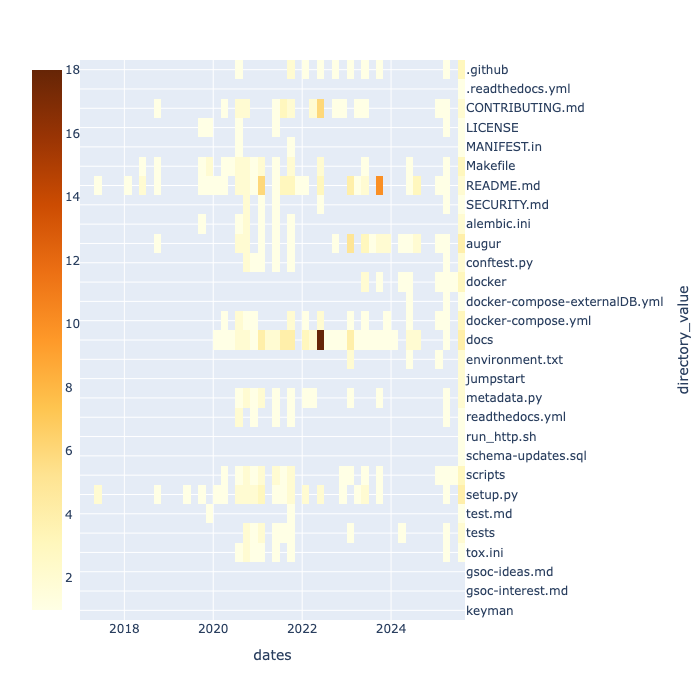

In [53]:
fig.write_image("heatmap_directory.png")
Image(filename="heatmap_directory.png")

On the 8knot side I am thinking about 2 drop downs. One to select the repo and one for the directory. The repo one will be populated with the contents of the search bar (need to talk about how to get that) with the one chooose in base case is the first one in the list. The second drop down will be searchable and will be all of the directories/folders that are in the specific repository. Top level will be the default